<a href="https://colab.research.google.com/github/SiyagJatin/Facial_recognition/blob/main/Facial_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import pathlib

In [2]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
!kaggle datasets download -d himanshuydv11/facial-emotion-dataset

Dataset URL: https://www.kaggle.com/datasets/himanshuydv11/facial-emotion-dataset
License(s): unknown
facial-emotion-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip facial-emotion-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: facial_emotion_dataset/dataset/Neutral/cropped_emotions.171781f.png  
  inflating: facial_emotion_dataset/dataset/Neutral/cropped_emotions.171782f.png  
  inflating: facial_emotion_dataset/dataset/Neutral/cropped_emotions.171784f.png  
  inflating: facial_emotion_dataset/dataset/Neutral/cropped_emotions.171785f.png  
  inflating: facial_emotion_dataset/dataset/Neutral/cropped_emotions.171786f.png  
  inflating: facial_emotion_dataset/dataset/Neutral/cropped_emotions.171787f.png  
  inflating: facial_emotion_dataset/dataset/Neutral/cropped_emotions.171788f.png  
  inflating: facial_emotion_dataset/dataset/Neutral/cropped_emotions.171789f.png  
  inflating: facial_emotion_dataset/dataset/Neutral/cropped_emotions.171790f.png  
  inflating: facial_emotion_dataset/dataset/Neutral/cropped_emotions.171791f.png  
  inflating: facial_emotion_dataset/dataset/Neutral/cropped_emotions.171792f.png  
  inflating: facial_emotion_dataset/

In [5]:
base_dir = 'facial_emotion_dataset/dataset'
data_dir = os.path.join(base_dir)
os.listdir(data_dir)

['Surprise', 'Angry', 'Happy', 'Ahegao', 'Neutral', 'Sad']

In [6]:
classes = ['Sad', 'Angry', 'Surprise', 'Neutral', 'Happy', 'Ahegao']

In [7]:
def show_image_and_distribution(classes):
    plt.figure(figsize=(15, 6))

    # Menampilkan gambar dari setiap kelas
    for i, class_name in enumerate(classes, 1):
        class_dir = os.path.join(data_dir, class_name)
        img_path = os.path.join(class_dir, os.listdir(class_dir)[0])
        img = mpimg.imread(img_path)

        # Menampilkan gambar
        plt.subplot(2, len(classes), i)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

        # Menghitung jumlah data dalam setiap kelas
        num_samples = len(os.listdir(class_dir))
        plt.subplot(2, len(classes), i+len(classes))
        plt.bar(class_name, num_samples)
        plt.title('Data Distribution')
        plt.xlabel('Class')
        plt.ylabel('Number of Samples')

    plt.tight_layout()
    plt.show()

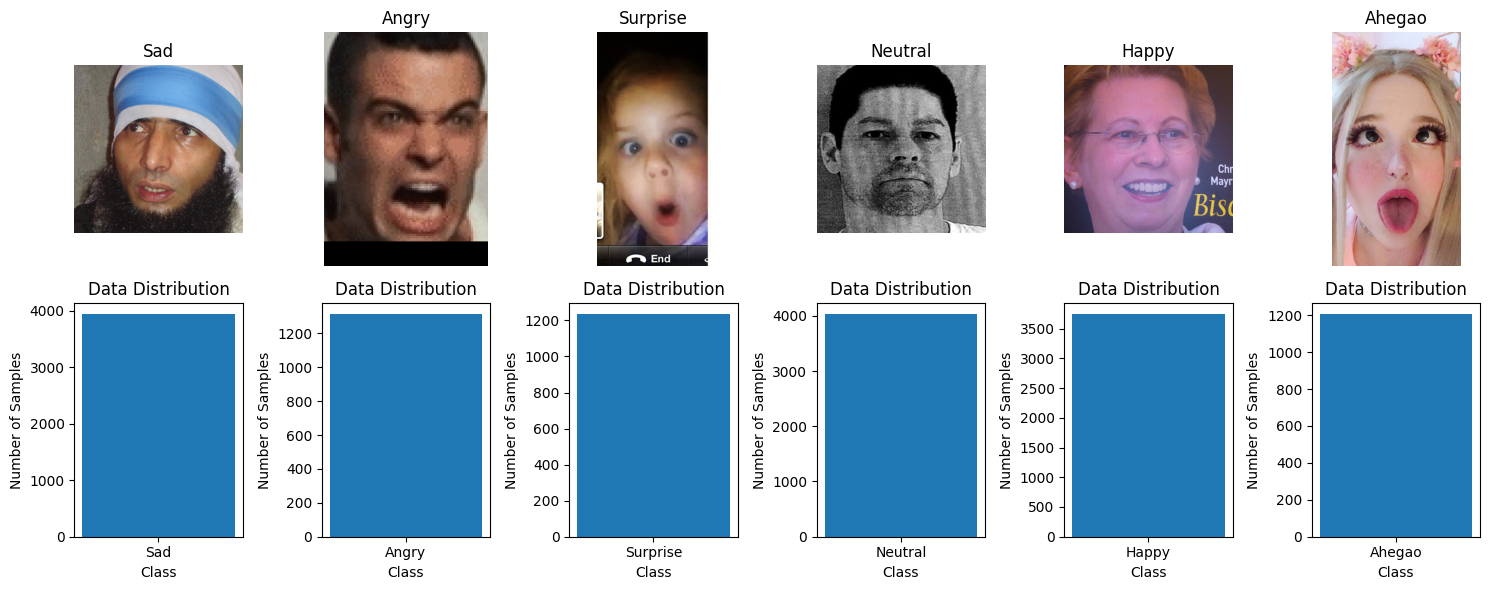

In [8]:
show_image_and_distribution(classes)

In [9]:
!mkdir data_fix
!mv facial_emotion_dataset/dataset/Happy data_fix/Happy
!mv facial_emotion_dataset/dataset/Neutral data_fix/Neutral
!mv facial_emotion_dataset/dataset/Sad data_fix/Sad

mkdir: cannot create directory ‘data_fix’: File exists


In [10]:
img_height = 64
img_width = 64
batch_size = 20

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
  rescale=1./255,
  rotation_range=90,
  horizontal_flip=True,
  vertical_flip=True,
  validation_split=0.2)

train_generator = datagen.flow_from_directory(
    "data_fix",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True,
)
val_generator = datagen.flow_from_directory(
    "data_fix",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=True,
)

Found 18723 images belonging to 3 classes.
Found 4679 images belonging to 3 classes.


In [11]:
model = tf.keras.models.Sequential([
    tf.keras.applications.EfficientNetV2S(weights="imagenet", include_top=False, input_tensor=tf.keras.layers.Input(shape=(img_width, img_height, 3))),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-s (Functional)   │ (None, 2, 2, 1280)     │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 1, 1, 1280)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,701,667 (78.97 MB)

 Trainable params: 20,547,283 (78.38 MB)

 Non-trainable params: 154,384 (603.06 KB)

In [12]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
class forCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95 and logs.get('val_accuracy')>0.95):
      self.model.stop_training = True
      print("good work")

callbacks = forCallback()

In [17]:
history = model.fit(
  train_generator,
  epochs=10,
  validation_data=val_generator,
  validation_steps=6,
  callbacks=[callbacks]
)
"I trained the model 4 times,So the total epochs are 40 not 10"

Epoch 1/10
937/937 ━━━━━━━━━━━━━━━━━━━━ 124s 132ms/step - accuracy: 0.8875 - loss: 0.2837 - val_accuracy: 0.8500 - val_loss: 0.3220
Epoch 2/10
937/937 ━━━━━━━━━━━━━━━━━━━━ 142s 152ms/step - accuracy: 0.8901 - loss: 0.2646 - val_accuracy: 0.8500 - val_loss: 0.3184
Epoch 3/10
937/937 ━━━━━━━━━━━━━━━━━━━━ 126s 134ms/step - accuracy: 0.8990 - loss: 0.2554 - val_accuracy: 0.8667 - val_loss: 0.3798
Epoch 4/10
937/937 ━━━━━━━━━━━━━━━━━━━━ 126s 135ms/step - accuracy: 0.8927 - loss: 0.2636 - val_accuracy: 0.8667 - val_loss: 0.3293
Epoch 5/10
937/937 ━━━━━━━━━━━━━━━━━━━━ 142s 135ms/step - accuracy: 0.8986 - loss: 0.2494 - val_accuracy: 0.8667 - val_loss: 0.2510
Epoch 6/10
937/937 ━━━━━━━━━━━━━━━━━━━━ 141s 133ms/step - accuracy: 0.9059 - loss: 0.2314 - val_accuracy: 0.8583 - val_loss: 0.4298
Epoch 7/10
937/937 ━━━━━━━━━━━━━━━━━━━━ 143s 134ms/step - accuracy: 0.9044 - loss: 0.2377 - val_accuracy: 0.8333 - val_loss: 0.4612
Epoch 8/10
937/937 ━━━━━━━━━━━━━━━━━━━━ 142s 151ms/step - accuracy: 0.9076 -